In [ ]:
import xgboost as xgb
import pandas as pd
import numpy as np
import optuna
import shap
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, StratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [7]:
df = pd.read_csv('MJD_TRAIN_PROCESSED.csv')

features = ['tdrift', 'tdrift50', 'tdrift10', 'rea', 'dcr', 'peakindex', 
            'peakvalue', 'tailslope', 'currentamp', 'lfpr', 'lq80', 
            'areagrowthrate', 'inflection point', 'risingedgeslope']

zeroes = df[df['truedcr'] == 0] 
"""for i in range(0, 15):
    df = pd.concat([df, zeroes])
    df = df.reset_index(drop = True)"""
df = df.dropna()
X = df[features]
y = df['truedcr']

#splitting into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)

In [ ]:
from imblearn.combine import SMOTETomek

smt = SMOTETomek(sampling_strategy=1, random_state=42)
X_resampled, y_resampled = smt.fit_resample(X, y)

print("Before:", Counter(y))
print("After:", Counter(y_resampled))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=21)

In [4]:
params ={
    'min_child_weight': [7],
    'gamma': [2],
    'subsample': [.8,],
    'colsample_bytree': [.9],
    'max_depth': [11],
    'n_estimators':[800,900,1000,1100],
    'learning_rate': [.08, .09, .1]
}

In [5]:
#create xgboost model and fit with previously found best parameters
xgb_clf = xgb.XGBClassifier(objective='binary:logistic',
                            min_child_weight = 5,
                            gamma = 1.8626758202468242e-08,
                            subsample = 0.8269137632223,
                            n_estimators = 424,
                            learning_rate = 0.2864045984520131,
                            colsample_bytree = 0.2864045984520131,
                            reg_alpha = 1.3289702380093151e-05,
                            reg_lambda = 0.24508489126080116,
                            max_depth = 12,
                            random_state=42)
xgb_clf.fit(X_resampled, y_resampled)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.2864045984520131, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None,
              gamma=1.8626758202468242e-08, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.2864045984520131, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=12, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=424, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [8]:
#first round of predictions on test split
y_pred = xgb_clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9932
Precision: 0.9994
Recall: 0.9937
F1 Score: 0.9965

Classification Report:
               precision    recall  f1-score   support

       False       0.75      0.97      0.85      6553
        True       1.00      0.99      1.00    331440

    accuracy                           0.99    337993
   macro avg       0.88      0.98      0.92    337993
weighted avg       0.99      0.99      0.99    337993



In [16]:
#testing the accuracy on our test data
df_test = pd.read_csv('MJD_TEST_PROCESSED.csv')
df_test = df_test.dropna()
X_test_dataset = df_test[features]  
y_test_dataset = df_test['truedcr']

y_pred_dataset = xgb_clf.predict(X_test_dataset)

accuracy_final = accuracy_score(y_test_dataset, y_pred_dataset)
precision_final = precision_score(y_test_dataset, y_pred_dataset)
recall_final = recall_score(y_test_dataset, y_pred_dataset)
f1_final = f1_score(y_test_dataset, y_pred_dataset)

print(f'Final Test Accuracy: {accuracy_final:.4f}')
print(f'Final Test Precision: {precision_final:.4f}')
print(f'Final Test Recall: {recall_final:.4f}')
print(f'Final Test F1 Score: {f1_final:.4f}')
print("\nFinal Test Classification Report:\n", classification_report(y_test_dataset, y_pred_dataset))

Final Test Accuracy: 0.9533
Final Test Precision: 0.9871
Final Test Recall: 0.9651
Final Test F1 Score: 0.9759

Final Test Classification Report:
               precision    recall  f1-score   support

       False       0.16      0.35      0.22      7421
        True       0.99      0.97      0.98    382573

    accuracy                           0.95    389994
   macro avg       0.57      0.66      0.60    389994
weighted avg       0.97      0.95      0.96    389994



In [19]:
#balancing our test data so that we can test accuracy
from collections import Counter
smt = SMOTETomek(sampling_strategy=1, random_state=42)
X_resampled, y_resampled = smt.fit_resample(X_test_dataset, y_test_dataset)

print("Before:", Counter(y))
print("After:", Counter(y_resampled))

Before: Counter({True: 1657733, False: 32232})
After: Counter({True: 376893, False: 376893})


In [26]:
#testing the accuracy on our test data
y_pred_dataset = xgb_clf.predict(X_resampled)

accuracy_final = accuracy_score(y_resampled, y_pred_dataset)
precision_final = precision_score(y_resampled, y_pred_dataset)
recall_final = recall_score(y_resampled, y_pred_dataset)
f1_final = f1_score(y_resampled, y_pred_dataset)

print(f'Final Test Accuracy: {accuracy_final:.4f}')
print(f'Final Test Precision: {precision_final:.4f}')
print(f'Final Test Recall: {recall_final:.4f}')
print(f'Final Test F1 Score: {f1_final:.4f}')
print("\nFinal Test Classification Report:\n", classification_report(y_resampled, y_pred_dataset))

Final Test Accuracy: 0.7913
Final Test Precision: 0.7161
Final Test Recall: 0.9653
Final Test F1 Score: 0.8223

Final Test Classification Report:
               precision    recall  f1-score   support

       False       0.95      0.62      0.75    376893
        True       0.72      0.97      0.82    376893

    accuracy                           0.79    753786
   macro avg       0.83      0.79      0.78    753786
weighted avg       0.83      0.79      0.78    753786



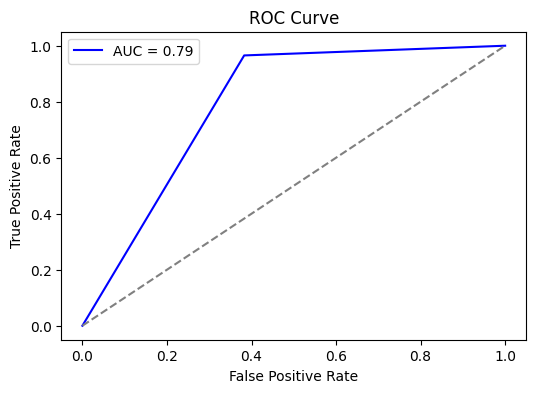

In [27]:
#plotting the Roc curve
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_resampled, y_pred_dataset)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color="blue", label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

Text(0.5, 1.0, 'Feature Importance (XGBoost)')

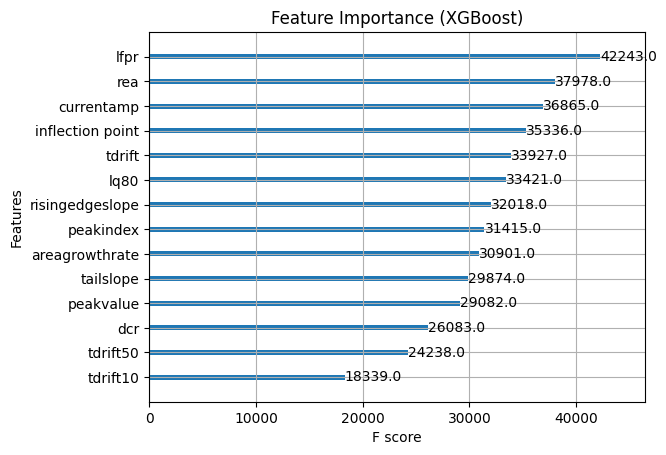

In [22]:
#getting the most important features
xgb.plot_importance(xgb_clf, importance_type="weight")
plt.title("Feature Importance (XGBoost)")

In [23]:
#testing the accuracy on our test data
df_test = pd.read_csv('MJD_NPML_PROCESSED.csv')
df_test = df_test.dropna()
X_test_dataset = df_test[features]  

y_pred_dataset = xgb_clf.predict(X_test_dataset)

In [14]:
#Saving our predictions
pd.DataFrame(y_pred_dataset).to_csv('truedcr.csv', index = False)